In [15]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

In [16]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

## Feature Building

In [17]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")

    X_quant_features = toxic_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

## Create training and test sets

In [18]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='toxiccomments_train.csv', my_random_seed=42)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Training Data

## Model: SVM Linear

In [19]:
from sklearn import linear_model
svm = linear_model.SGDClassifier(loss='hinge', penalty='elasticnet', alpha=0.001, l1_ratio=0.5, fit_intercept=True, max_iter=1000, tol=0.001, shuffle=True, verbose=0, epsilon=0.1, n_jobs=None, random_state=None, learning_rate='optimal', eta0=0.0, power_t=0.5, early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, class_weight=None, warm_start=False, average=False)
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 12981, 'Neg': 114675, 'TP': 11352, 'TN': 113880, 'FP': 795, 'FN': 1629, 'Accuracy': 0.981011468321113, 'Precision': 0.9345517411706594, 'Recall': 0.8745088976195978, 'desc': 'svm_train'}


### Looking at some false positives

In [20]:
svm_predictions = svm.predict(X_train)

# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(svm_predictions)):
    if (svm_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')

Examples of false positives:
2413
Yet another thanks 

Looks like you keep yourself busy doing this sort of thing, but I'll add my thanks to the list for fixing the stupid vandalism on my User Page.
* * * * * * * * * 
9764
Cheers man. To be honest, I laughed my arse out in front of my laptop today. You guys are so funny attacking a beginner and that definitely made my day. Me and my girlfriend just can't stop laughing, seriously, hellish ghoul? ))))). Thanks for your advice I'll consider reading policies tomorrow. Now, the article is not complete, data must be obviously changed and content put in order and completed. However, I'll decide whether to go on or give up this wikipedia thing, since I like reality and palpable history, which is obviously not the case here. Wikipedia is more likely to fit (or create some) American history and culture. Thanks man and forgive my mistakes. They were on purpose. Best of luck to you guys.
* * * * * * * * * 
14598
Elonka RFC

I'm considering putting

80167
Don't be a douche, CKATZ.
* * * * * * * * * 
81117
Someone Ban Me So My misery posting here is over
I am trying hard as hell to be an A$$ to get banned. Make it permanent please. I can then get back to being productive. Well I am waiting. 172.56.11.104
* * * * * * * * * 
90388
A JEW?  OR NOT A JEW?
* * * * * * * * * 
91371
I am all for a RFC, but moderators should prevent you from flooding the RFC with irrelevancies. I am OK with Encyclopedia's and Dictionaries policies about the usage of foreign languages use. But you have to convince others that a words original version usage should be equivalent to the usage of modern creation.
* * * * * * * * * 
93445
Lol, you are too busy doing what now?   Maybe you don't realize it, but no one gives a shit about anything you're doing, because it's a waste of time and no one will ever read it
* * * * * * * * * 
93553
Hey Asspro 
I left a disparaging remark about you on the helpdesk. Enjoy.
* * * * * * * * * 
94777
"  I'm simply leaving out n

### ROC plot for training data

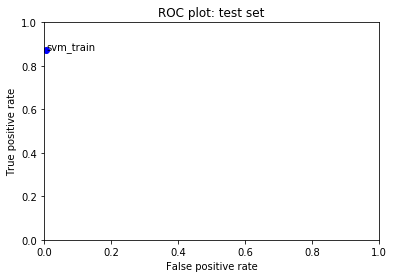

In [21]:
fits = [svm_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

# Test Data

In [23]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3244, 'Neg': 28671, 'TP': 2357, 'TN': 28067, 'FP': 604, 'FN': 887, 'Accuracy': 0.9532821557261476, 'Precision': 0.796014859844647, 'Recall': 0.7265721331689272, 'desc': 'svm_test'}


In [24]:
# read in test data for submission
raw_data, X_test_submission = process_raw_data(fn='toxiccomments_test.csv', my_random_seed=42, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0          72          10
1          13           1
2          16           0
3          38           3
4           7           1
5          16           2
6          31           4
7           6       

In [25]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = svm.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.22704421404507585


In [26]:
### ROC plot for test data

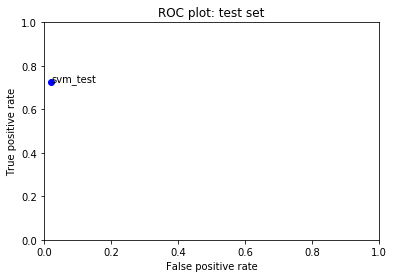

In [27]:
fits = [svm_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()